In [66]:
!pip install evaluate

In [67]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
import evaluate
import pandas as pd
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class InferenceModel:
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", offload_buffers=True)
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        self.model.eval()
        self.logits = []
    def init_eval(self):
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        
    def get_logprobs(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        outputs = self.model(**inputs, output_hidden_states=True)
        logits = outputs.logits
        # Shape remains, but values are now normalized as log probabilities over the vocabulary.
        logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
        return logprobs, outputs
        
    def inference(self, prompt, max_new_tokens=1):
        """
        Performs inference on a given prompt.
        Returns the decodede output
        """
        generated_text = ''
        len_sentence = 0
        if self.model_name == 'Qwen/Qwen2.5-0.5B-Instruct':
            # WARNING: messages ini harus sama dengan messages di check_index_prompt
            messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)
            
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            len_sentence = len(self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["input_ids"])
        elif self.model_name == "google/gemma-2-2b-it":
            # WARNING: messages ini harus sama dengan messages di check_index_prompt
            messages = [
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt", add_special_tokens=False).to(self.model.device)
            # print(f"(model_inputs['input_ids'] {(model_inputs['input_ids'])}")
            
            # print(f"len(model_inputs['input_ids'] {len(model_inputs['input_ids'])}")
            sentence_token_texts = self.tokenizer.convert_ids_to_tokens((model_inputs['input_ids'])[0])
            # print(f"sentence_token_texts {sentence_token_texts}")
            
            
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            len_sentence = len(self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["input_ids"])
            # print()
            
        else:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
            len_sentence = len(inputs["input_ids"])
            output = self.model.generate(
                **inputs, 
                do_sample=False,
                temperature=None,
                top_p=None,
                top_k=None,
                max_new_tokens=1)
            # print(f"output: {output}")
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        
        self.answers.append(generated_text)
        # answer = "1" if "option1" in generated_text else "2" if "option2" in generated_text else None
        
        return generated_text, len_sentence

    def batch_inference(self, prompts):
        """
        Perform batch inference.
        """
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=50)
        generated_texts = []
        for input_ids, output_ids in zip(inputs.input_ids, outputs):
            generated_ids = [
                output_ids[len(input_ids):]
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            generated_texts.append(generated_text)
        self.answers.extend(generated_texts)
        return generated_texts

    def eval(self):
        """
        Evaluates the predictions against the references 
        """
        accuracy_results = self.acc_metric.compute(predictions=self.predictions, references=self.references)

        precision_results = self.precision_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        recall_results = self.recall_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        results = {
            'acc' : accuracy_results,
            'prec' : precision_results,
            'recall' : recall_results
        }
        self.eval_results.append(results)
        print("Evaluation Results:\n", results)
        return results

    
    def parse_save_output(self, generated_text, unique_labels, current_labeltexts, currentlabel):
        """
        generated_text: output from model.generate (e.g. '1', 'option 1', 'anna')
        unique_labels: unique labels from dataset (list of string e.g. ["1", "2"])
        current_labeltexts: the current label options (dict of current label text e.g. {1:'anna', 2:'susan'})
        currentlabel = the current reference label from dataset (string, the dataset['answer']. e.g. "2", "1" )
        """
        pred = None
        clean_generated_text = generated_text.lower().strip()
        for i in unique_labels:
            if str(i) in clean_generated_text or current_labeltexts[int(i)].lower().strip() in clean_generated_text or current_labeltexts[int(i)].lower().removeprefix("the").strip() in clean_generated_text :
                pred = i
                break
        # print(f"gt: {generated_text}")
        # print(f"pred : {pred}")
        if pred == None:
            pred = "9"
        self.predictions.append(pred)
        self.references.append(currentlabel)
        ans_dict = ({'pred_answer':pred, 'pred_answertext' : generated_text})
        # print(f"ans_dict {ans_dict}")
        self.df.loc[len(self.df)] = ans_dict
        return pred



In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
massive_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)

In [70]:
massive_qwen.model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [71]:
import pandas as pd

# Define column names
columns = [
    "intervention",
    "LAPE 1%",
    "LAPE 2%", 
    "LAPE 5%",
    "Manually Set Differenced", 
    "Distribution Method max", 
    "Distribution Method > 99th percentile", 
    "Spearman Rho"
]

# Create an empty DataFrame
df = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df)
df = pd.DataFrame(np.nan, index=range(6), columns=columns)  # Fill with NaN initially
df["intervention"] = ['baseline', "indo", "malay", "java", "vietnam", "eng"]


import pandas as pd

# Define column names
columns = [
    "intervention",
    "LAPE 1%",
    "LAPE 2%", 
    "LAPE 5%",
    "Manually Set Differenced", 
    "Distribution Method max", 
    "Distribution Method > 99th percentile", 
    "Spearman Rho"
]

# Create an empty DataFrame
df_flipped = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df_flipped)

df_flipped = pd.DataFrame(np.nan, index=range(6), columns=columns)  # Fill with NaN initially
df_flipped["intervention"] = ['baseline', "indo", "malay", "java", "vietnam", "eng"]





Empty DataFrame
Columns: [intervention, LAPE 1%, LAPE 2%, LAPE 5%, Manually Set Differenced, Distribution Method max, Distribution Method > 99th percentile, Spearman Rho]
Index: []
Empty DataFrame
Columns: [intervention, LAPE 1%, LAPE 2%, LAPE 5%, Manually Set Differenced, Distribution Method max, Distribution Method > 99th percentile, Spearman Rho]
Index: []


# LAPE

In [72]:
def LAPE(activation_probs, top_rate = 0.01,filter_rate=0.95,activation_bar_ratio=0.95):
    """    
    activation_probs = # layer x inter x lang_num
    """    
    num_layers = activation_probs.size(0)
    normed_activation_probs = activation_probs / activation_probs.sum(dim=-1, keepdim=True)
    normed_activation_probs[torch.isnan(normed_activation_probs)] = 0
    log_probs = torch.where(normed_activation_probs > 0, normed_activation_probs.log(), 0)
    entropy = -torch.sum(normed_activation_probs * log_probs, dim=-1)
    largest = False
    
    if torch.isnan(entropy).sum():
        print(torch.isnan(entropy).sum())
        raise ValueError
    
    flattened_probs = activation_probs.flatten()
    top_prob_value = flattened_probs.kthvalue(round(len(flattened_probs) * filter_rate)).values.item()
    print(top_prob_value)
    # dismiss the neruon if no language has an activation value over top 90%
    top_position = (activation_probs > top_prob_value).sum(dim=-1)
    entropy[top_position == 0] = -torch.inf if largest else torch.inf

    flattened_entropy = entropy.flatten()
    top_entropy_value = round(len(flattened_entropy) * top_rate)
    _, index = flattened_entropy.topk(top_entropy_value, largest=largest)
    row_index = index // entropy.size(1)
    col_index = index % entropy.size(1)
    selected_probs = activation_probs[row_index, col_index] # n x lang
    # for r, c in zip(row_index, col_index):
    #     print(r, c, activation_probs[r][c])

    # print(selected_probs.size(0), torch.bincount(selected_probs.argmax(dim=-1)))
    selected_probs = selected_probs.transpose(0, 1)
    activation_bar = flattened_probs.kthvalue(round(len(flattened_probs) * activation_bar_ratio)).values.item()
    # print((selected_probs > activation_bar).sum(dim=1).tolist())
    lang, indice = torch.where(selected_probs > activation_bar)

    merged_index = torch.stack((row_index, col_index), dim=-1)
    final_indice = []
    for _, index in enumerate(indice.split(torch.bincount(lang).tolist())):
        lang_index = [tuple(row.tolist()) for row in merged_index[index]]
        lang_index.sort()
        layer_index = [[] for _ in range(num_layers)]
        for l, h in lang_index:
            layer_index[l].append(h)
        for l, h in enumerate(layer_index):
            layer_index[l] = torch.tensor(h).long()
        final_indice.append(layer_index)
    return final_indice

In [73]:
def get_prob_for_lape(tensor, num_lang, num_layer, num_neurons):
    """
    num_neurons: intermediate layer (neurons in a layer)
    """
    full_languages_raw_values = (tensor.transpose(0,1)[0] > 0).half()
    probs = full_languages_raw_values.mean(dim=-2)
    probs.shape
    del full_languages_raw_values
    probs = probs.reshape(num_lang,num_layer,num_neurons)
    transposed_probs = probs.transpose(0,1).transpose(-1,-2)
    transposed_probs.shape
    return transposed_probs

def convert_to_global_indices(final_indice, intermediate_size):
    final_flattened = []
    
    for lang_idx, layers in enumerate(final_indice):  # Iterate over languages
        global_indices = []
        for layer_idx, hidden_units in enumerate(layers):  # Iterate over layers
            if hidden_units.numel() > 0:  # If there are selected neurons
                global_indices.extend((layer_idx * intermediate_size + hidden_units).tolist())
        
        final_flattened.append((global_indices))  
    
    return final_flattened



In [74]:
import numpy as np
from scipy.stats import entropy
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_k_lang_actv_dict(k, full_neurons, method="default", topk=0):
    
    """
    di sini anggap activated neuron (avg token) yang di setiap row di dataset(cuman 2 row) actv valuenya > 0.
    k = num language"""
    activation_dict = {}
    
    full_neurons = full_neurons.transpose(-3,-4)[0].transpose(-1,-2)

    if method == "default":
        for i in range (full_neurons.size(0)):
            tensor_lang = full_neurons[i]
            rows_with_both_positive = (tensor_lang > 0).all(dim=-1)
            
            indices = torch.where(rows_with_both_positive)[0]
            activation_dict[i] = indices
            # indices.shape
            # print(indices.shape)
    elif method == "topk":
        if topk==0:
            print(f"topk must not be 0")
        top = (full_neurons.mean(dim=-1).topk(topk).indices)
        for i in range (full_neurons.size(0)):
            activation_dict[i] = top[i]
    
    return activation_dict

# Step 1: Convert lists to probability distributions
def to_probability_distribution(values):
    total = sum(values)
    return [v / total for v in values]


def make_heatmap_neuron_overlap(activation_dict, k, with_label=True, method="default", alpha=1, normalized =False):    
    # Example dictionary: keys 0-52, values are 1D tensors of activated neuron indices
    # activation_dict = get_k_lang_actv_dict(10)

    overlap_matrix = torch.tensor([])
    if method == "default":
        # Step 1: Create a binary matrix
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
        
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  # Set activated neurons to 1
        
        # Step 2: Compute overlaps (dot product between rows)
        overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose

    elif method == "jaccard":
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)
    
        # Fill binary matrix with activation data
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  
    
        # Compute Jaccard distance matrix
        overlap_matrix = torch.zeros((k+1, k+1))
    
        for i in range(k+1):
            for j in range(k+1):
                intersection = (binary_matrix[i] & binary_matrix[j]).sum().item()
                union = (binary_matrix[i] | binary_matrix[j]).sum().item()
                jaccard_similarity = intersection / union if union > 0 else 0
                overlap_matrix[i, j] = jaccard_similarity
        overlap_matrix = overlap_matrix ** alpha
        if normalized:
            overlap_matrix = overlap_matrix / overlap_matrix.sum(axis=1, keepdims=True)

    
    # Step 3: Visualize the heatmap
    plt.figure(figsize=(10, 8))
    if with_label:
        sns.heatmap(overlap_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                    xticklabels=range(k+1), yticklabels=range(k+1))
    else:
        sns.heatmap(overlap_matrix.numpy(), fmt="d", cmap="YlOrRd",cbar=True)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title(f"Overlap Heatmap of Activated Neurons: {method}")
    plt.show()
    return overlap_matrix


def normed_heatmap_neuron_overlap(num_lang, activation_dict):
    # Step 1: Create a binary matrix
    max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
    binary_matrix = torch.zeros((num_lang, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
    
    for key, indices in activation_dict.items():
        binary_matrix[key, indices] = 1  # Set activated neurons to 1
    
    # Step 2: Compute overlaps (dot product between rows)
    overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose
    
    # Step 3: Normalize the overlap matrix
    # Compute the number of activated neurons for each key
    num_activated_neurons = binary_matrix.sum(dim=1, keepdim=True)
    
    # Normalize by the minimum number of activated neurons between each pair of keys
    normalized_overlap_matrix = overlap_matrix / torch.minimum(
        num_activated_neurons, num_activated_neurons.T
    )
    
    # Ensure the diagonal is exactly 1 (self-overlap is always 1)
    normalized_overlap_matrix.fill_diagonal_(1)
    
    # Step 4: Visualize the normalized heatmap (no labels or annotations)
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_overlap_matrix.numpy(), cmap="YlOrRd", cbar=True, vmin=0, vmax=1)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title("Normalized Overlap Heatmap of Activated Neurons")
    plt.show()

In [75]:

def visualize_lape(full_languages_raw_values, num_layer, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80): 
    num_lang, _, num_rows, num_neurons = full_languages_raw_values.shape
    
    per_layer = int(num_neurons/num_layer)
    transposed_probs = get_prob_for_lape(full_languages_raw_values, num_lang, num_layer, per_layer)
    lape = LAPE(transposed_probs, top_rate = top_rate,filter_rate=filter_rate,activation_bar_ratio=activation_bar_ratio)
    flattened_indices = convert_to_global_indices(lape, per_layer)
    activation_dict = dict()
    for i in range (num_lang):
        activation_dict[i] = flattened_indices[i]
    make_heatmap_neuron_overlap(activation_dict, num_lang, False, "jaccard", 1)
    return lape

In [76]:
languages = {
    0: 'Afrikaans (af-ZA)',
    1: 'Amharic (am-ET)',
    2: 'Arabic (ar-SA)',
    3: 'Azerbaijani (az-AZ)',
    4: 'Bengali (bn-BD)',
    5: 'Catalan (ca-ES)',
    6: 'Welsh (cy-GB)',
    7: 'Danish (da-DK)',
    8: 'German (de-DE)',
    9: 'Greek (el-GR)',
    10: 'English (en-US)',
    11: 'Spanish (es-ES)',
    12: 'Persian (fa-IR)',
    13: 'Finnish (fi-FI)',
    14: 'French (fr-FR)',
    15: 'Hebrew (he-IL)',
    16: 'Hindi (hi-IN)',
    17: 'Hungarian (hu-HU)',
    18: 'Armenian (hy-AM)',
    19: 'Indonesian (id-ID)',
    20: 'Icelandic (is-IS)',
    21: 'Italian (it-IT)',
    22: 'Japanese (ja-JP)',
    23: 'Javanese (jv-ID)',
    24: 'Georgian (ka-GE)',
    25: 'Khmer (km-KH)',
    26: 'Kannada (kn-IN)',
    27: 'Korean (ko-KR)',
    28: 'Latvian (lv-LV)',
    29: 'Malayalam (ml-IN)',
    30: 'Mongolian (mn-MN)',
    31: 'Malay (ms-MY)',
    32: 'Burmese (my-MM)',
    33: 'Norwegian Bokmål (nb-NO)',
    34: 'Dutch (nl-NL)',
    35: 'Polish (pl-PL)',
    36: 'Portuguese (pt-PT)',
    37: 'Romanian (ro-RO)',
    38: 'Russian (ru-RU)',
    39: 'Slovenian (sl-SL)',
    40: 'Albanian (sq-AL)',
    41: 'Swedish (sv-SE)',
    42: 'Swahili (sw-KE)',
    43: 'Tamil (ta-IN)',
    44: 'Telugu (te-IN)',
    45: 'Thai (th-TH)',
    46: 'Tagalog (tl-PH)',
    47: 'Turkish (tr-TR)',
    48: 'Urdu (ur-PK)',
    49: 'Vietnamese (vi-VN)',
    50: 'Chinese (Simplified) (zh-CN)',
    51: 'Chinese (Traditional) (zh-TW)'
}

In [77]:
def clean_hooks(infer_model):
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()
def test_inference(infer_model, prompt, max_new_tokens):
    generated_text = infer_model.inference(prompt, max_new_tokens)
    # print(f"data: {prompt}")
            
    print(f"gen_text {generated_text}")
def set_activation_mlp(name, lape_lang, is_multiplied, replace_value): 
    """
        name (str): buat namain layer
        lape_lang: lape untuk suatu lang
        is_multiplied: (bool) true if multiplied else replaced
    """
    # TODO: coba di bagian promptnya aja jangan chat template
    def hook_fn(module, input, output):
        # print(f"output {output.shape}")
        layer = int(name)
        if is_multiplied:
            output[0, :, lape_lang[layer]] *= replace_value
        else:
            output[0, :, lape_lang[layer]] = replace_value
    return hook_fn


def intervensi(prompt, infer_model, lape_lang, num_layers, max_new_tokens, is_multiplied, replace_value):
    clean_hooks(infer_model)
    handlers = []
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(f"{i}", lape_lang, is_multiplied, replace_value)))
    test_inference(infer_model, prompt, max_new_tokens)
    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

def intervene_langs(infer_model, prompt_lang, lape_langs, num_layers, max_new_tokens=10, is_multiplied=False, replace_value=0):
    """
    given a prompt, from number of languages, see how intervention each language affects the prompt.
    infer_model: InferenceModel
    prompt_lang: (str) prompt dalam bahasa tertentu
    lape_langs: (dict) key: lang, value: lape in a language
    """
    print(f"original: ")
    test_inference(infer_model, prompt_lang, max_new_tokens)
    for key, value in lape_langs.items():
        print(f"intervensi {languages[key]}")
        intervensi(prompt_lang, infer_model, value, num_layers, max_new_tokens, is_multiplied, replace_value)


### 🐸Massive Qwen

In [78]:
import torch
full_languages_raw_values = torch.load("/kaggle/input/raw-qwen05-predict-200/raw_qwen05_predict_massive200_selected_v.pt", weights_only=False)


In [79]:
infer_model = massive_qwen
num_layers = 24

### 2%

0.445068359375


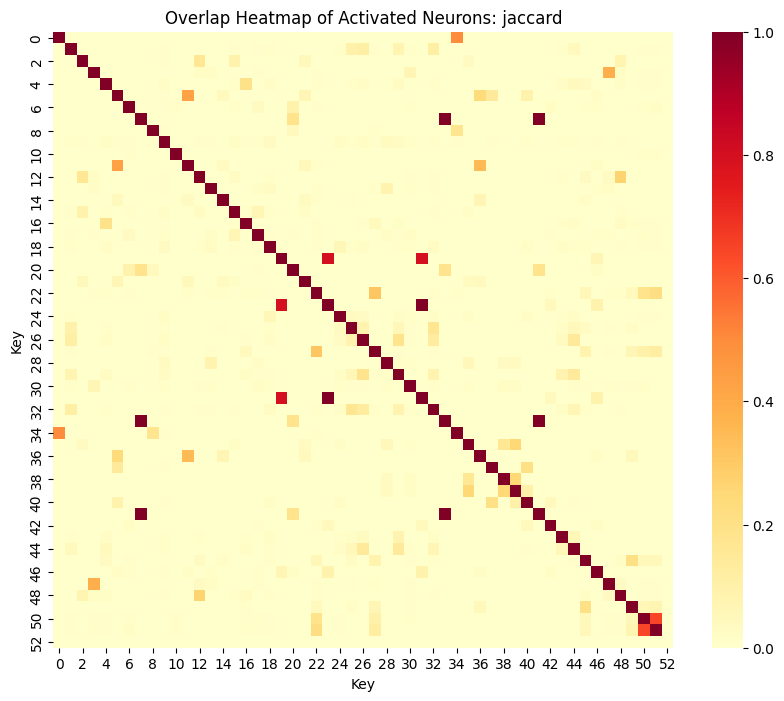

In [80]:
lape_massive_qwen_2 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.02,filter_rate=0.80,activation_bar_ratio=0.80)

In [81]:
lape_langs = {key:lape_massive_qwen_2[key] for key, value in enumerate(lape_massive_qwen_2)}
# lape_langs

In [82]:
# lape_langs = {
#     "indo" : lape_massive_qwen[19],
#     "malay" : lape_massive_qwen[31],
#     'java' : lape_massive_qwen[23],
#     'eng': lape_massive_qwen[10]
# }
prompt_indo = "gugah aku jam sanga esuk dina jumat"
intervene_langs(
    infer_model, prompt_indo, lape_langs, num_layers, max_new_tokens=30, is_multiplied=True, replace_value=3)

original: 
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Afrikaans (af-ZA)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Amharic (am-ET)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan Anda tentang kejadian atau situasi yang terjadi di hari Jumat. Saya', 42)
intervensi Arabic (ar-SA)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Azerbaijani (az-AZ)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Bengali (bn-BD)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Catalan (ca-ES)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Welsh (cy-GB)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi Danish (da-DK)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
intervensi German (de-DE)
gen_text ('Maaf, saya tidak bisa membantu d

In [83]:
prompt_malay = "kejutkan saya pada pukul sembilan pagi hari jumaat"
intervene_langs(
    infer_model, prompt_malay, lape_langs, num_layers, max_new_tokens=30, is_multiplied=False, replace_value=0)

original: 
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda tentang jam yang tepat untuk Jumaat. Jumaat adalah hari yang', 47)
intervensi Afrikaans (af-ZA)
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda tentang jam waktu yang diberikan:\n\nPukul 7:00', 47)
intervensi Amharic (am-ET)
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda:\n\nPukul sembilan pagi hari Jumat adalah 08', 47)
intervensi Arabic (ar-SA)
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan tepat waktu dan sesuai dengan waktu yang diberikan. Semoga', 47)
intervensi Azerbaijani (az-AZ)
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan tepat waktu. Pukul sembilan pagi hari Jumat', 47)
intervensi Bengali (bn-BD)
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan tepat waktu. Pukul sembilan pagi hari Jumat', 47)
intervensi Catalan (ca-ES)
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda tentang jam waktu yang tepat untuk Jumaat. Jumaat adalah h

In [84]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=2a208f882b2b722352143fee688f55f2e3d87218369558363be5e2c5b3c7987b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [85]:
clean_hooks(infer_model)

In [86]:
import torch
import torch.nn.functional as F
from langdetect import detect, detect_langs

def generate_and_compute_perplexity(infer_model, tokenizer, prompt, lang_prompt,
                                    lang_intervensi, lape_lang, 
                                    is_multiplied, 
                                    replace_by, max_new_tokens):
    # Prepare messages in the same format as used in generation
    model = infer_model.model
    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the input
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    clean_hooks(infer_model)
    handlers = []
    if lang_intervensi:
        # print("ini intervensi")
        for i in range (num_layers):
            mlp = model.model.layers[i].mlp
            handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(f"{i}", lape_lang, is_multiplied, replace_by)))
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            do_sample=False,  # Use deterministic decoding
            temperature=None,
            top_p=None,
            top_k=None,
            max_new_tokens=max_new_tokens
        )

    # Extract the newly generated text
    generated_text = tokenizer.decode(generated_ids[0][model_inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Combine prompt + generated text
    full_text = text + generated_text

    # Re-tokenize full input (prompt + generated response)
    full_inputs = tokenizer([full_text], return_tensors="pt").to(model.device)

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**full_inputs)
        logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

    # Tokenize only the generated text for loss computation
    generated_ids = tokenizer(generated_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    generated_len = generated_ids.shape[1]

    # Align logits with the generated tokens
    shift_logits = logits[:, -generated_len-1:-1, :]
    shift_labels = generated_ids  # Targets are the generated tokens

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))

    # Convert to perplexity
    perplexity = torch.exp(loss).item()
    accuracy = 1 if detect(generated_text) == lang_prompt[:2] else 0    # Print generated text and perplexity
    # print(f"Generated Text: {generated_text}")
    # print(f"Detected languages {detect(generated_text)}")
    # print(f"Perplexity: {perplexity}")
    # print(f"Accuracy: {accuracy}")

    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

    return generated_text, perplexity, accuracy

# Example usage
ppls = []
accs = []
prompt = "batalkan alarm saya pukul tujuh pagi"
generated_text, ppl, acc = generate_and_compute_perplexity(
                                    infer_model, infer_model.tokenizer, 
                                    prompt, "id",
                                    lang_intervensi=None, lape_lang=None, 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)



untuk prompt indo:


Generated Text: Tentu saja, saya akan membantu Anda mengatasi masalah alarm Anda. Berikut
Perplexity: 1.5995888710021973

Generated Text: I apologize, but I'm not able to assist with that. If you're having trouble with your
Perplexity: 1.521577000617981



In [87]:
import numpy as np
def accuracy_weighted_perplexity(accuracy_list, perplexity_list):
    if len(accuracy_list) != len(perplexity_list):
        raise ValueError("Accuracy and perplexity lists must have the same length")

    # Compute max log perplexity dynamically
    max_log_ppl = np.log(max(perplexity_list))

    # Compute scores for each sample
    scores = [
        acc * (1 - (np.log(ppl) / max_log_ppl)) 
        for acc, ppl in zip(accuracy_list, perplexity_list)
    ]

    return scores, np.mean(scores), np.mean(accuracy_list), np.mean(perplexity_list)  # List of individual scores


In [88]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


def get_ppl_massive(infer_model, max_instances, lang_prompt, lang_intervensi=None, lape_lang=None, 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20):
    eval_result = {}
    all_languages = []
    num_layers = len(infer_model.model.model.layers)
    handlers = []
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    
    dataset_name = "AmazonScience/massive"
    configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
    n_instances = 0
    n_lang = 0
    language_dict = {}
    ppls = []
    accs = []
    for lang in [lang_prompt]:
        ds = load_dataset(dataset_name, lang, split="train")
        for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
            if n_instances >= max_instances:
                break
            utterance = data['utt']
            generated_text, ppl, acc = generate_and_compute_perplexity(
                                    infer_model, infer_model.tokenizer, 
                                    utterance, lang_prompt,
                                    lang_intervensi=lang_intervensi, lape_lang=lape_lang, 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
            accs.append(acc)
            ppls.append(ppl)
            
            n_instances += 1
            # break
        n_lang += 1
        print(f"Done with lang: {lang}")
        n_instances = 0
    scores, avg_score, acc, ppl = accuracy_weighted_perplexity(accs, ppls)
    return scores, avg_score, acc, ppl
            



baseline

In [89]:
lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen


In [90]:
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi=None, lape_lang=None, 
is_multiplied=False, 
replace_by=0, max_new_tokens=20)

README.md:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

massive.py:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

id-ID%2Ftrain%2F0000.parquet:   0%|          | 0.00/734k [00:00<?, ?B/s]

id-ID%2Fvalidation%2F0000.parquet:   0%|          | 0.00/149k [00:00<?, ?B/s]

id-ID%2Ftest%2F0000.parquet:   0%|          | 0.00/204k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: id-ID


In [91]:
print(avg_score)

0.3662091487394057


In [92]:
scores, b_avg_score, b_acc, b_ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi=None, lape_lang=None, 
is_multiplied=False, 
replace_by=0, max_new_tokens=20)

Done with lang: id-ID


### intervene on neurons ABLATED

2%

In [93]:
intv_scores_massive_qwen = dict()
intv_scores_massive_qwen['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_massive_qwen_2[19], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_massive_qwen_2[31], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_massive_qwen_2[23], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_massive_qwen_2[49], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_massive_qwen_2[10], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: 0.07088776184373968


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: 0.08435055058159724


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: 0.07100840522222973


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: 0.3769634367546847


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on english neurons: 0.4435898184605843


5%

0.445068359375


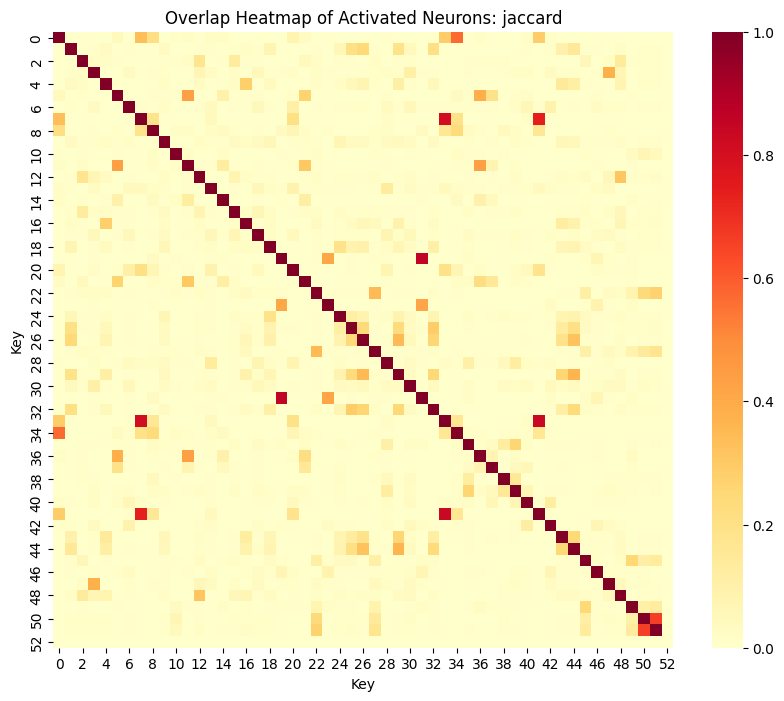

In [94]:
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)

In [95]:
intv_scores_massive_qwen_5 = dict()
intv_scores_massive_qwen_5['baseline'] = (b_acc, b_ppl, b_avg_score) 



lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_langs[19], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_langs[31], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_langs[23], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_langs[49], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_langs[10], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on indonesian neurons: 0.041374106796218744


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on malaysian neurons: 0.05553510135339565


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on javanese neurons: 0.02754418039004528


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on vietnamese neurons: 0.4007697698165884


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on english neurons: 0.2801272443176063


In [96]:
lape_2_values = []
for key, val in intv_scores_massive_qwen.items():
    lape_2_values.append(val)
lape_2_values

[(0.94, 1.913519082069397, 0.3662091487394057),
 (0.14, 2.420679850578308, 0.07088776184373968),
 (0.16, 2.423536868095398, 0.08435055058159724),
 (0.14, 2.423536868095398, 0.07100840522222973),
 (0.94, 1.8673844456672668, 0.3769634367546847),
 (0.9, 1.9324391198158264, 0.4435898184605843)]

In [97]:
lape_5_values = []
for key, val in intv_scores_massive_qwen_5.items():
    lape_5_values.append(val)
lape_5_values

[(0.94, 1.913519082069397, 0.3662091487394057),
 (0.08, 3.4851449966430663, 0.041374106796218744),
 (0.1, 3.4858025550842284, 0.05553510135339565),
 (0.06, 3.025048944950104, 0.02754418039004528),
 (0.86, 2.055850405693054, 0.4007697698165884),
 (0.9, 1.903927755355835, 0.2801272443176063)]

In [98]:
df["LAPE 2%"] = lape_2_values
df["LAPE 5%"] = lape_5_values

In [99]:
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,intervention,LAPE 1%,LAPE 2%,LAPE 5%,Manually Set Differenced,Distribution Method max,Distribution Method > 99th percentile,Spearman Rho
0,baseline,NaN,"(0.94, 1.913519082069397, 0.3662091487394057)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN,NaN,NaN,NaN
1,indo,NaN,"(0.14, 2.420679850578308, 0.07088776184373968)","(0.08, 3.4851449966430663, 0.041374106796218744)",NaN,NaN,NaN,NaN
2,malay,NaN,"(0.16, 2.423536868095398, 0.08435055058159724)","(0.1, 3.4858025550842284, 0.05553510135339565)",NaN,NaN,NaN,NaN
3,java,NaN,"(0.14, 2.423536868095398, 0.07100840522222973)","(0.06, 3.025048944950104, 0.02754418039004528)",NaN,NaN,NaN,NaN
4,vietnam,NaN,"(0.94, 1.8673844456672668, 0.3769634367546847)","(0.86, 2.055850405693054, 0.4007697698165884)",NaN,NaN,NaN,NaN
5,eng,NaN,"(0.9, 1.9324391198158264, 0.4435898184605843)","(0.9, 1.903927755355835, 0.2801272443176063)",NaN,NaN,NaN,NaN


### intervene on neurons FLIPPED (multp by -1)

0.445068359375


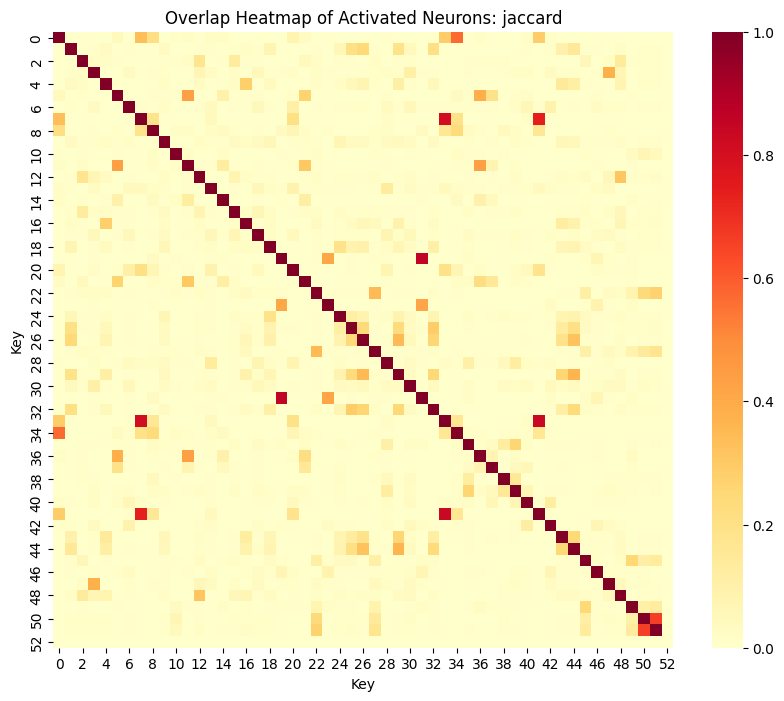

In [100]:
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)


In [101]:
intv_scores_massive_qwen_flipped = dict()
intv_scores_massive_qwen_flipped['baseline'] = (b_acc, b_ppl, b_avg_score)



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_massive_qwen_2[19], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_flipped["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_massive_qwen_2[31], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_flipped["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_massive_qwen_2[23], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_flipped["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_massive_qwen_2[49], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_flipped["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_massive_qwen_2[10], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_flipped["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: 0.0


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: 0.0


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: 0.0


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: 0.4044362058786326


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on english neurons: 0.30687305775981066


In [102]:
intv_scores_massive_qwen_5_flipped = dict()
intv_scores_massive_qwen_5_flipped['baseline'] = (b_acc, b_ppl, b_avg_score)



lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_langs[19], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_langs[31], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_langs[23], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_langs[49], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_langs[10], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on indonesian neurons: 0.015897615869248195


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on malaysian neurons: 0.04379207995785641


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on javanese neurons: 0.018958592231527717


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on vietnamese neurons: 2.846080852242361e-05


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on english neurons: 0.3018095381677613


In [103]:
lape_2_values = []
for key, val in intv_scores_massive_qwen_flipped.items():
    lape_2_values.append(val)
lape_2_values

lape_5_values = []
for key, val in intv_scores_massive_qwen_5_flipped.items():
    lape_5_values.append(val)
lape_5_values


df_flipped["LAPE 2%"] = lape_2_values
df_flipped["LAPE 5%"] = lape_5_values

In [104]:
df_flipped

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,intervention,LAPE 1%,LAPE 2%,LAPE 5%,Manually Set Differenced,Distribution Method max,Distribution Method > 99th percentile,Spearman Rho
0,baseline,NaN,"(0.94, 1.913519082069397, 0.3662091487394057)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN,NaN,NaN,NaN
1,indo,NaN,"(0.0, 2.9017166686058045, 0.0)","(0.06, 2.1717709255218507, 0.015897615869248195)",NaN,NaN,NaN,NaN
2,malay,NaN,"(0.0, 2.6375824332237245, 0.0)","(0.08, 2.148380675315857, 0.04379207995785641)",NaN,NaN,NaN,NaN
3,java,NaN,"(0.0, 2.6375824332237245, 0.0)","(0.08, 2.1666747331619263, 0.018958592231527717)",NaN,NaN,NaN,NaN
4,vietnam,NaN,"(0.96, 1.8803886771202087, 0.4044362058786326)","(0.02, 3.971725733280182, 2.846080852242361e-05)",NaN,NaN,NaN,NaN
5,eng,NaN,"(0.86, 1.86433114528656, 0.30687305775981066)","(0.88, 1.9095749711990357, 0.3018095381677613)",NaN,NaN,NaN,NaN


# DIST METHOD

In [105]:
lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen
num_layers = 24



In [106]:
import torch
dist_neurons_max = torch.load("/kaggle/input/distribution-method-90/dist_neurons_max", weights_only=False)
len(dist_neurons_max)

52

In [107]:
import torch
dist_neurons_99 = torch.load("/kaggle/input/distribution-method-90/dist_neurons_99", weights_only=False)
len(dist_neurons_99)

52

In [108]:
lape_langs = {key:dist_neurons_max[key] for key, value in enumerate(dist_neurons_max)}

prompt_malay = "bangunkan saya jam sembilan pagi hari jumat"
intervene_langs(
    infer_model, prompt_malay, lape_langs, num_layers, max_new_tokens=20, is_multiplied=False, replace_value=0)

original: 
gen_text ('Tentu saja, saya akan membantu Anda dengan mengubah "jam sembilan pagi', 42)
intervensi Afrikaans (af-ZA)
gen_text ("Sorry, I can't assist with that.", 42)
intervensi Amharic (am-ET)
gen_text ("Sorry, but I can't assist with that.", 42)
intervensi Arabic (ar-SA)
gen_text ('Tentu saja, saya akan membantu Anda dengan mengubah waktu yang Anda inginkan menjadi', 42)
intervensi Azerbaijani (az-AZ)
gen_text ('Tentu saja, saya akan membantu Anda dengan mengubah "jam sembilan pagi', 42)
intervensi Bengali (bn-BD)
gen_text ('Tentu saja, saya akan bangun saya di jam sembilan pagi hari Jumat', 42)
intervensi Catalan (ca-ES)
gen_text ("Tentu saja! Here's how you can bangun at 7:00 AM on", 42)
intervensi Welsh (cy-GB)
gen_text ('Tentu saja, saya akan bangun saya di jam sembilan pagi hari Jumat', 42)
intervensi Danish (da-DK)
gen_text ('Tentu saja, saya akan membantu Anda dengan informasi tentang jam yang sesuai untuk jam', 42)
intervensi German (de-DE)
gen_text ('Tentu saja, s

### intervene on neurons ABLATED

max

In [109]:
method = "dist method"
tipe ="max"
act_lang =  {key:dist_neurons_max[key] for key, value in enumerate(dist_neurons_max)}

intv_scores_massive_qwen_dm_max = dict()
intv_scores_massive_qwen_dm_max['baseline'] = (b_acc, b_ppl, b_avg_score)  

lape_langs

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on indonesian neurons: 0.4456386065619262


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on malaysian neurons: 0.39387469400638975


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on javanese neurons: 0.41083519054155276


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on vietnamese neurons: 0.25701078035745717


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on english neurons: 0.34471935265334713


above percentile 99

In [110]:
# TODO: change the config 

method = "dist method"
tipe ="> 99th percentile"
act_lang =  {key:dist_neurons_99[key] for key, value in enumerate(dist_neurons_99)}
is_multiplied = False
replace_by = 0
max_new_tokens = 20

temp = dict()
temp['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
temp["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
temp["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
temp["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
temp["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
temp["en"] = (acc, ppl, avg_score)

# TODO: change the name 
intv_scores_massive_qwen_dm_99 = temp

Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on indonesian neurons: 0.4319866222817555


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on malaysian neurons: 0.517128361521618


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on javanese neurons: 0.3967672082722047


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on vietnamese neurons: 0.06006446355992799


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on english neurons: 0.2778558993532115


In [111]:
dm_max = []
for key, val in intv_scores_massive_qwen_dm_max.items():
    dm_max.append(val)

dm_99 = []
for key, val in intv_scores_massive_qwen_dm_99.items():
    dm_99.append(val)

df["Distribution Method max"] = dm_max
df["Distribution Method > 99th percentile"] = dm_99

### intervene on neurons flipped (mult by -1)

In [112]:
# TODO: change the config 

method = "dist method"
tipe ="max"
act_lang =  {key:dist_neurons_max[key] for key, value in enumerate(dist_neurons_max)}
is_multiplied = False
replace_by = 0
max_new_tokens = 20

temp = dict()
temp['baseline'] = (b_acc, b_ppl, b_avg_score)  



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
temp["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
temp["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
temp["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
temp["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
temp["en"] = (acc, ppl, avg_score)

# TODO: change the name 
intv_scores_massive_qwen_dm_max_flipped = temp

Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on indonesian neurons: 0.4456386065619262


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on malaysian neurons: 0.39387469400638975


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on javanese neurons: 0.41083519054155276


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on vietnamese neurons: 0.26740567400662496


Done with lang: id-ID
avg_score intervention indonesian prompt with max dist method on english neurons: 0.34471935265334713


In [113]:
# TODO: change the config 

method = "dist method"
tipe ="> 99th percentile"
act_lang =  {key:dist_neurons_99[key] for key, value in enumerate(dist_neurons_99)}
is_multiplied = True
replace_by = 1
max_new_tokens = 20

temp = dict()
temp['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
temp["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
temp["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
temp["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
temp["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
temp["en"] = (acc, ppl, avg_score)

# TODO: change the name 
intv_scores_massive_qwen_dm_99_flipped = temp

Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on indonesian neurons: 0.3662091487394057


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on malaysian neurons: 0.3662091487394057


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on javanese neurons: 0.3662091487394057


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on vietnamese neurons: 0.3662091487394057


Done with lang: id-ID
avg_score intervention indonesian prompt with > 99th percentile dist method on english neurons: 0.3662091487394057


In [114]:
dm_max = []
for key, val in intv_scores_massive_qwen_dm_max_flipped.items():
    dm_max.append(val)

dm_99 = []
for key, val in intv_scores_massive_qwen_dm_99_flipped.items():
    dm_99.append(val)

df_flipped["Distribution Method max"] = dm_max
df_flipped["Distribution Method > 99th percentile"] = dm_99

In [115]:
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,intervention,LAPE 1%,LAPE 2%,LAPE 5%,Manually Set Differenced,Distribution Method max,Distribution Method > 99th percentile,Spearman Rho
0,baseline,NaN,"(0.94, 1.913519082069397, 0.3662091487394057)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN,"(0.3662091487394057, 0.94, 1.913519082069397)","(0.3662091487394057, 0.94, 1.913519082069397)",NaN
1,indo,NaN,"(0.14, 2.420679850578308, 0.07088776184373968)","(0.08, 3.4851449966430663, 0.041374106796218744)",NaN,"(0.94, 1.9320499753952027, 0.4456386065619262)","(0.88, 2.008747675418854, 0.4319866222817555)",NaN
2,malay,NaN,"(0.16, 2.423536868095398, 0.08435055058159724)","(0.1, 3.4858025550842284, 0.05553510135339565)",NaN,"(0.94, 1.9672346758842467, 0.39387469400638975)","(0.94, 2.321515498161316, 0.517128361521618)",NaN
3,java,NaN,"(0.14, 2.423536868095398, 0.07100840522222973)","(0.06, 3.025048944950104, 0.02754418039004528)",NaN,"(0.92, 2.0019926857948303, 0.41083519054155276)","(0.92, 2.0976311135292054, 0.3967672082722047)",NaN
4,vietnam,NaN,"(0.94, 1.8673844456672668, 0.3769634367546847)","(0.86, 2.055850405693054, 0.4007697698165884)",NaN,"(0.66, 1.9404482698440553, 0.25701078035745717)","(0.18, 1.8828551936149598, 0.06006446355992799)",NaN
5,eng,NaN,"(0.9, 1.9324391198158264, 0.4435898184605843)","(0.9, 1.903927755355835, 0.2801272443176063)",NaN,"(0.96, 1.8855056405067443, 0.34471935265334713)","(0.86, 2.0577804112434386, 0.2778558993532115)",NaN


In [116]:
df_flipped

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,intervention,LAPE 1%,LAPE 2%,LAPE 5%,Manually Set Differenced,Distribution Method max,Distribution Method > 99th percentile,Spearman Rho
0,baseline,NaN,"(0.94, 1.913519082069397, 0.3662091487394057)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN,"(0.3662091487394057, 0.94, 1.913519082069397)","(0.3662091487394057, 0.94, 1.913519082069397)",NaN
1,indo,NaN,"(0.0, 2.9017166686058045, 0.0)","(0.06, 2.1717709255218507, 0.015897615869248195)",NaN,"(0.94, 1.9320499753952027, 0.4456386065619262)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN
2,malay,NaN,"(0.0, 2.6375824332237245, 0.0)","(0.08, 2.148380675315857, 0.04379207995785641)",NaN,"(0.94, 1.9672346758842467, 0.39387469400638975)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN
3,java,NaN,"(0.0, 2.6375824332237245, 0.0)","(0.08, 2.1666747331619263, 0.018958592231527717)",NaN,"(0.92, 2.0019926857948303, 0.41083519054155276)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN
4,vietnam,NaN,"(0.96, 1.8803886771202087, 0.4044362058786326)","(0.02, 3.971725733280182, 2.846080852242361e-05)",NaN,"(0.68, 1.9404482698440553, 0.26740567400662496)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN
5,eng,NaN,"(0.86, 1.86433114528656, 0.30687305775981066)","(0.88, 1.9095749711990357, 0.3018095381677613)",NaN,"(0.96, 1.8855056405067443, 0.34471935265334713)","(0.94, 1.913519082069397, 0.3662091487394057)",NaN
